In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.iclr.helper import load_multiple_version_of_pcs
from tf_lab.neural_net import MODEL_SAVER_ID

from pcloud_benchmark.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence
from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, point_cloud_generator,\
leaky_relu, mlp_discriminator

PyTorch not working. MMD measurement won't be available


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
save_model = False
do_training = True
save_synthetic_samples = np.hstack([np.array([1,5,10]), np.arange(50, 2001, 50)])
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/synthetic_samples/r_gan/'

Give me the class type.
chair


In [5]:
n_pc_points = 2048
max_epochs = 2000
arch_tag = 'mlp_disc_4_fc_gen'

leak = 0.2
dropout_prob = None

discriminator = mlp_discriminator
adaptive_training = None

beta = 0.2
disc_kwargs = {'non_linearity': leaky_relu(leak),  'dropout_prob': dropout_prob, 'b_norm': False}

generator = point_cloud_generator

gen_kwargs = {'b_norm': False, 'dropout_prob': dropout_prob}

experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_points) +  '_pts'

In [6]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)

Loading test data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/test.txt
679 pclouds were loaded. They belong in 1 shape-classes.
Loading train data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/train.txt
5761 pclouds were loaded. They belong in 1 shape-classes.
Loading val data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/val.txt
338 pclouds were loaded. They belong in 1 shape-classes.


In [7]:
training_data = in_data['train']

batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = 128
init_lr = 0.0001

n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [8]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_points, 3], noise_dim,
             discriminator, generator, beta=beta, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

1 (1.3593876361846924, 0.7086533090342646) 27.1418869495


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


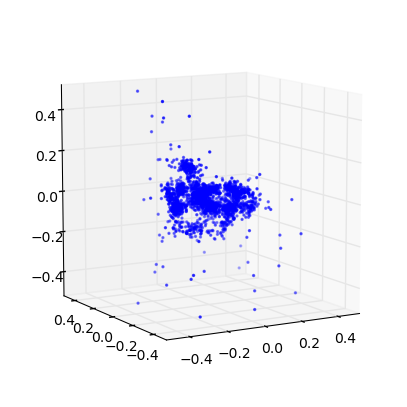

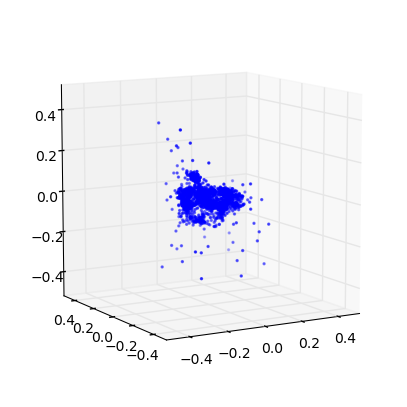

2 (1.3425923865774403, 0.73959276676177976) 26.8213889599
3 (1.2509805845177693, 0.84629063450771824) 26.9805340767
4 (1.2497155225795249, 0.91858234198197075) 27.3351070881
5 (1.3298408518666807, 0.75005561942639554) 27.2066640854


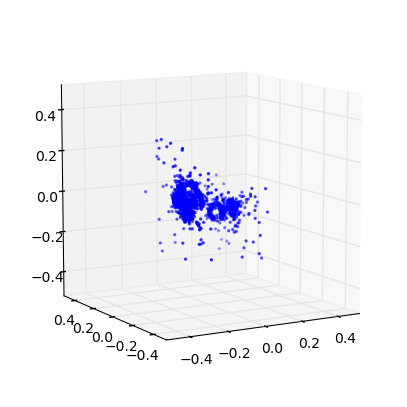

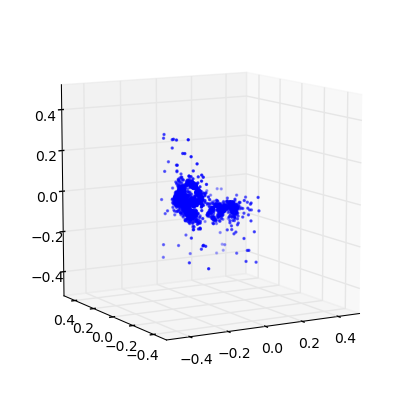

6 (1.3039232513178949, 0.78146555682887198) 27.2364220619
7 (1.3021390800890715, 0.7884117147196894) 27.1088421345
8 (1.3181415112122246, 0.79170411203218538) 27.4953548908
9 (1.3265796889429506, 0.76965942330982373) 27.4474239349
10 (1.3310495718665745, 0.76335088688394293) 27.3353838921


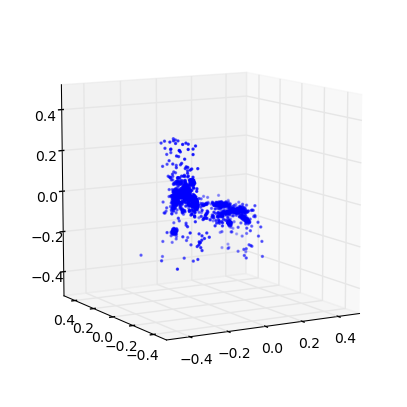

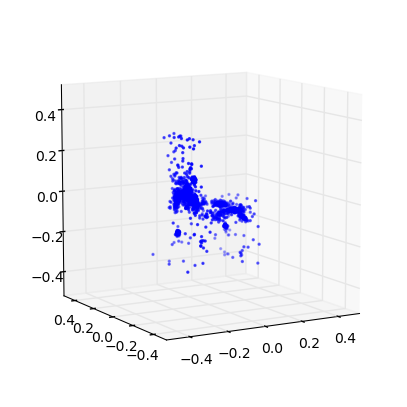

11 (1.3277338898700217, 0.76787629904954324) 27.1805839539
12 (1.3193020167558089, 0.77223110069399292) 27.159058094
13 (1.3107330923495086, 0.78190204060595969) 27.2061018944
14 (1.3073307949563731, 0.78194608170053237) 27.1340801716
15 (1.3079511455867601, 0.7869054001310597) 27.4002120495
16 (1.3136501301889834, 0.78813172190085701) 27.0982151031
17 (1.3188852279082588, 0.79007131897884864) 27.2576420307
18 (1.3351261988930081, 0.78768913979115696) 27.0973670483
19 (1.332552725335826, 0.77849023290302444) 27.4031271935
20 (1.3222458404043447, 0.76852565900139191) 27.2776310444
21 (1.3255929552990457, 0.77917817571888803) 27.1855859756
22 (1.3249755693518597, 0.78506856405216718) 27.1044960022
23 (1.3212594944497813, 0.78279664827429729) 27.254349947
24 (1.3233026017313418, 0.78126482911731887) 27.108850956
25 (1.3303657780522886, 0.77349991798400874) 27.257789135
26 (1.3478200114291647, 0.7664800317391105) 27.3204829693
27 (1.3340331544046817, 0.76329496269640718) 27.187417984
28 (1

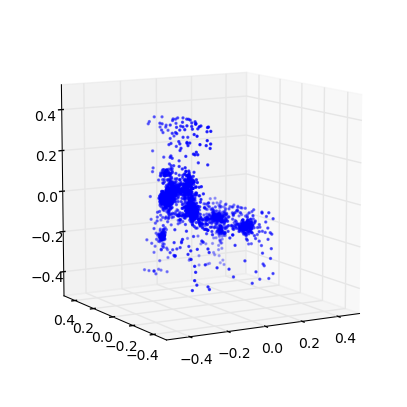

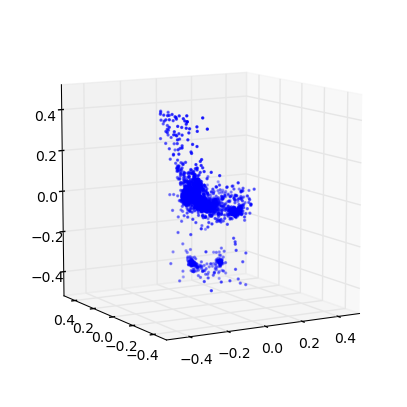

51 (1.3495280825573466, 0.76297210351280542) 27.3477540016
52 (1.35337000929791, 0.75986611454383191) 27.1326050758
53 (1.3549552336983059, 0.76152908180070955) 27.2818720341
54 (1.3495791082796844, 0.75594141846117768) 27.1368541718
55 (1.3541744636452717, 0.75394969919453492) 27.1356058121
56 (1.3550666819448056, 0.75622862888419107) 27.297878027
57 (1.3557052125101503, 0.75543837080831111) 27.0786011219
58 (1.3540747373000435, 0.75148256602494612) 27.4470479488
59 (1.3588155964146489, 0.75447674238163487) 27.292634964
60 (1.3560674729554549, 0.7540153503417969) 27.1506519318
61 (1.355646366658418, 0.75889052100803545) 27.2928349972
62 (1.3542595386505127, 0.75375995998797207) 27.0947818756
63 (1.355687025318975, 0.75765232210573941) 27.5745561123
64 (1.3564900750699251, 0.7557239744974219) 27.2792170048
65 (1.3518872406171716, 0.75352725775345508) 27.0838999748
66 (1.3574773042098336, 0.75438261809556384) 27.5841379166
67 (1.3605373341104259, 0.75682092775469245) 27.3617169857
68 (1

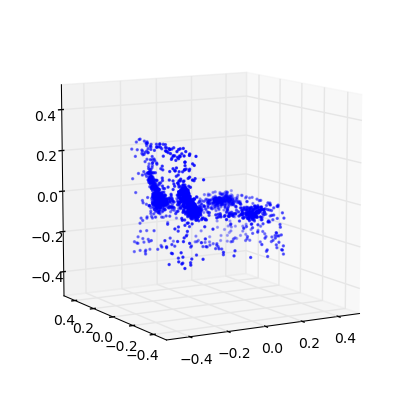

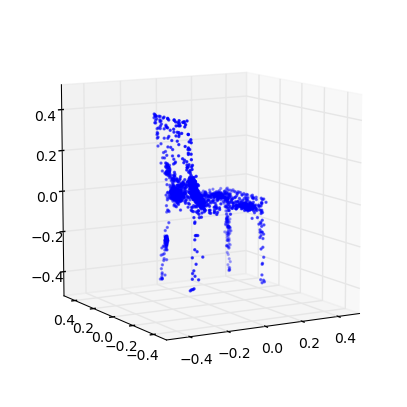

101 (1.3545415878295899, 0.76171451729276907) 27.151432991
102 (1.3538483650788018, 0.76142808717230093) 27.0990650654
103 (1.3582950529844864, 0.76232105338055156) 27.1826398373
104 (1.3559234857559204, 0.75625858099564258) 27.1023509502
105 (1.3539119699726934, 0.76275362890699638) 27.3696908951
106 (1.355525809785594, 0.76218507911847988) 27.3267400265
107 (1.3501984223075536, 0.76113673448562624) 27.1048560143


In [ ]:
save_syn_data_dir = create_dir(osp.join(synthetic_data_out_dir, experiment_name))

if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model and epoch % 10 == 0:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            
        if epoch in save_synthetic_samples:
            syn_data = gan.generate(n_syn_samples, noise_params)
            accum_syn_data.append(syn_data)
            np.savez(osp.join(save_syn_data_dir, 'epoch_' + str(epoch)), syn_data)            
            for k in range(2):
                Point_Cloud(syn_data[k]).plot()
#         train_stats.append((epoch,) + loss)

In [ ]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')

In [ ]:
epoch_to_check = 1500
n_check = 5
check_data = accum_syn_data[(epoch_to_check / 10)-1]
rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)
for i in range(n_check):
    Point_Cloud(check_data[rids[i]]).plot(in_u_sphere=True)    

In [ ]:
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/our_synthetic_samples/'
saver_step = 10
if save_synthetic_samples:    
    create_dir(save_dir)
    for i, d in enumerate(accum_syn_data):
        epoc = str((i + 1) * saver_step)
        np.savez(osp.join(save_dir, 'epoch_' + epoc), d)